In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from mtj.calc_Heff import calc_Heff
from mtj.calc_Hth import compute_thermal_field
from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY

### Demonstration of Magnetization Computation

This notebook utilize some core components of our mtj Python library to compute the magnetization of a magnetic sample. In this demonstration, we perform the simulations on a thin film of soft magnetic material (Permalloy), with $M_S\approx1 \space \text{T}$, and a demagnetization tensor with $N_{xx}=N_{yy} = 0$ and $N_{zz}=1$.

In [2]:
def calculate_magnetization(
    m0: npt.NDArray[np.float64],
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.5,  # Damping factor
    K_u=0,  # Crystal anisotropy constant, default: 0
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.zeros(3, dtype=np.float64),  # Not used when K_0 = 0
    N=np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]),  # Default: "infinite" thin film
    H_th=np.zeros(3, dtype=np.float64),  # Default:  zero thermal field
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))

    for i, t in enumerate(time_series[:-1]):
        # Calculate the effective field
        H_eff = calc_Heff(
            m[i],
            K_u,
            M_s,
            u_k,
            np.zeros(3, dtype=np.float64), # No STT
            0, # No STT
            0, # No STT
            V=0, # No STT
            H_app=H_app,
            N=N,
            stt_enable=False, # No STT
        )

        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(m[i], H_eff, H_th, dt, alpha)

    return m, time_series

We start without thermal fluctuations or STT, finding the equilibrium state when we set $K_u=0$ for a couple of different initial magnetizations. We observe that the equilibrium state is when the magnetization lies in the xy-plane.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_14896/1025381297.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


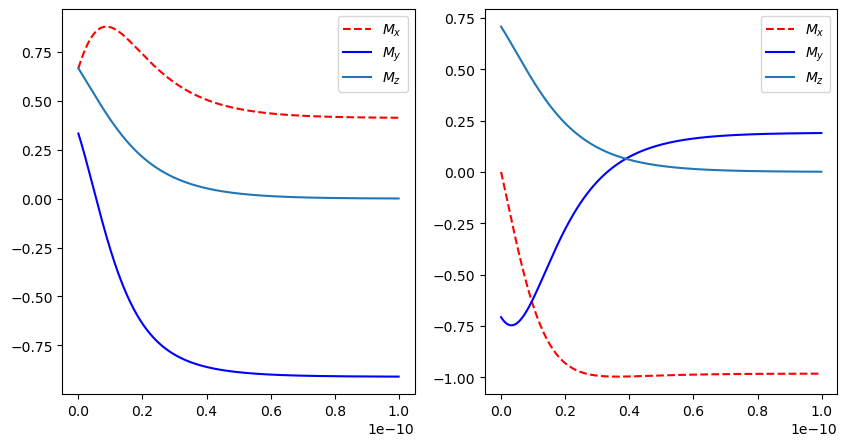

In [3]:
m, t = calculate_magnetization(m0=np.array([1, 0.5, 1]), H_app=np.zeros(3))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[0].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[0].plot(t, m[:, 2], label=r"$M_z$")

ax[0].legend()

m, t = calculate_magnetization(m0=np.array([0, -1, 1]), H_app=np.zeros(3))

ax[1].plot(t, m[:, 0], "r--", label=r"$M_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$M_y$")
ax[1].plot(t, m[:, 2], label=r"$M_z$")

ax[1].legend()

fig.show()